# Homework 3 - Tikhonova Maria

In [2]:
%pylab inline
import os
import pandas
import urllib2
from skimage import io, color
from skimage import draw
from __future__ import division
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color, exposure
import math
from scipy.ndimage.interpolation import zoom
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import RandomizedPCA
from time import time
import scipy
import random
import pandas

Populating the interactive namespace from numpy and matplotlib


# HOG

In [3]:
test_dir = '/home/masha/Desktop/Shad5/Pictures/HW3/test/'
train_dir = '/home/masha/Desktop/Shad5/Pictures/HW3/train/'
basic_dir = '/home/masha/Desktop/Shad5/Pictures/HW3/'

Сначала взгялнем на знаки, которые нам предстоит классифицировать.

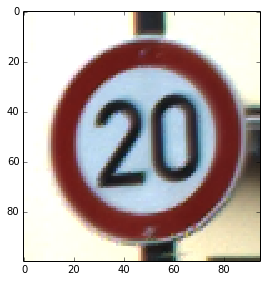

In [3]:
img = io.imread("00147.png")
io.imshow(img)
io.show()

А теперь приступим к извлечению HOG признаков из изображения.

In [4]:
def normalise_histogram(orientation_histogram, bx, by, n_cells_x, n_cells_y, nbins):
    eps = 1e-7
    
    if bx==1 and by==1: #faster version
        normalised_blocks = orientation_histogram / np.sqrt(orientation_histogram.sum(axis=-1)**2 + eps)[:, :, np.newaxis]
        ##normalised_blocks /= np.sqrt(normalised_blocks.sum(axis=-1)**2 + eps)[:, :, np.newaxis]
        
    else:
        n_blocksx = (n_cells_x - bx) + 1
        n_blocksy = (n_cells_y - by) + 1
        normalised_blocks = np.zeros((n_blocksy, n_blocksx, nbins))

        for x in range(n_blocksy):
            for y in range(n_blocksx):
                block = orientation_histogram[y:y + by, x:x + bx, :]
                normalised_blocks[y, x, :] = np.clip(block[0, 0, :] / np.sqrt(block.sum()**2 + eps), 0, 0.2)
                normalised_blocks[y, x, :] /= np.sqrt(normalised_blocks[y, x, :].sum()**2 + eps)

    return normalised_blocks

Свертка возможна с различными ядрами.

In [9]:
def calc_magnitude_orientation(image, simple_kernel = True):
    if simple_kernel:
        gx = np.zeros(image.shape)
        gx[:, 1:-1] = -image[:, :-2] + image[:, 2:]
        gx[:, 0] = -image[:, 0] + image[:, 1]
        gx[:, -1] = -image[:, -2] + image[:, -1]
    
        gy = np.zeros(image.shape)
        gy[1:-1, :] = image[:-2, :] - image[2:, :]
        gy[0, :] = image[0, :] - image[1, :]
        gy[-1, :] = image[-2, :] - image[-1, :]
        
    else:
        gx = np.zeros(image.shape)
        gx[0, 1:-1] = -image[0, :-2] + image[0, 2:]
        gx[-1, 1:-1] = -image[-1, :-2] + image[-1, 2:]
        gx[1:-1, 1:-1] = -2 * image[1:-1, :-2] + 2 * image[1:-1, 2:]
        gx[:, 0] = -image[:, 0] + image[:, 1]
        gx[:, -1] = -image[:, -2] + image[:, -1]
        
        gy = np.zeros(image.shape)
        gy[1:-1, 0] = image[:-2, 0] - image[2:, 0]
        gy[1:-1, -1] = image[:-2, -1] - image[2:, -1]
        gy[1:-1, 1:-1] = 2 * image[:-2, 1:-1] - 2 * image[2:, 1:-1]
        gy[0, :] = image[0, :] - image[1, :]
        gy[-1, :] = image[-2, :] - image[-1, :]
    
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = ((arctan2(gy, gx) / np.pi))
    return magnitude, orientation

Самая важная часть программы по извлечению HOG признаков, где и производится построение диаграммы.

In [10]:
def calc_hists(magnitude, orientation, cell_size=(8, 8), cells_per_block=(1, 1), n_bins = 9):
    sy, sx = magnitude.shape
    csy, csx = cell_size
    orientation_histogram = np.zeros((sy, sx, n_bins))
    by, bx = cells_per_block
    x = np.linspace(0, csy - 1.0/sx, sx).astype('int')
    y = np.linspace(0, csx - 1.0/sy, sy).astype('int')
    
    x_hist, y_hist = np.meshgrid(x, y)
    orientation_histogram = np.zeros([y_hist.max() + 1, x_hist.max() + 1, n_bins])
    for i in range(x_hist.max() + 1):
        for j in range(y_hist.max() + 1):
            hist, edges = np.histogram(orientation[(x_hist == i) & (y_hist == j)], 
                                                bins=n_bins, range=(-np.pi, np.pi),
                                                weights=magnitude[(x_hist == i) & (y_hist == j)])
            orientation_histogram[j, i] = hist
    return orientation_histogram  

def calc_HOG(image, cell_size=(8, 8), cells_per_block=(1, 1), n_bins = 9, simple_kernel = True):
    magnitude, orientation = calc_magnitude_orientation(image, simple_kernel)
    return calc_hists(magnitude, orientation, cell_size, cells_per_block, n_bins)

Визуализация получившейся гистограммы HOG.

In [13]:
def draw_hist(hist, cell_size=(16, 16)):
    csx, csy = cell_size
    max_angle = 2*np.pi
    
    n_cells_y, n_cells_x, nbins = hist.shape
    sx, sy = n_cells_x*csx, n_cells_y*csy
    center = csx//2, csy//2
    b_step = max_angle / nbins

    radius = min(csx, csy) // 2 - 1
    hog_image = np.zeros((sy, sx), dtype=float)
    for x in range(n_cells_x):
        for y in range(n_cells_y):
            for o in range(nbins):
                centre = tuple([y * csy + csy // 2, x * csx + csx // 2])
                dx = radius * np.cos(o*nbins)
                dy = radius * np.sin(o*nbins)
                rr, cc = draw.line(int(centre[0] - dy),
                                   int(centre[1] - dx),
                                   int(centre[0] + dy),
                                   int(centre[1] + dx))
                hog_image[rr, cc] += hist[y, x, o]
    return hog_image

По названию файла загружается картинка, для которой извлекаются HOG признаки и строится диаграмма.

In [14]:
def extract_hog(filename, cell_size=(16, 16), cells_per_block=(1, 1), n_bins = 9, visualise = False, simple_kernel = True):
    img = io.imread(filename)
    image = color.rgb2gray(img)
    hog_hist = calc_HOG(image, cell_size=(16, 16), cells_per_block=cells_per_block, n_bins = n_bins, simple_kernel = simple_kernel)
    if visualise:
        hog_image = draw_hist(hog_hist, cell_size = cell_size)
        plt.figure()
        plt.title('HOG features')
        plt.imshow(hog_image, cmap=plt.cm.Greys_r)
    return hog_hist

Проверим работу extrac_HOG на отдельном изображении.

Результат работы с первым ядром.

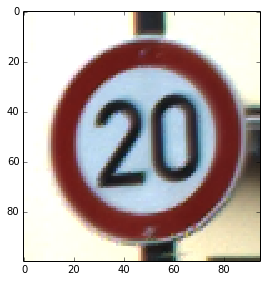

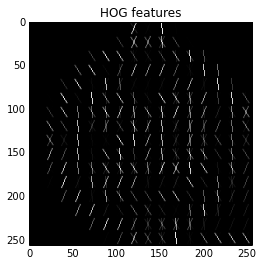

In [15]:
##im1 = zoom(image, 3)
img = io.imread("00147.png")
image = color.rgb2gray(img)

cell_size = (16, 16)
cells_per_block=(8, 8)
n_bins = 9
hog_hist = calc_HOG(image, cell_size=(16, 16), cells_per_block=cells_per_block, n_bins = n_bins)
hog_image = draw_hist(hog_hist, cell_size = cell_size)

plt.show()
io.imshow(img)
io.show()
plt.figure()
plt.title('HOG features')
plt.imshow(hog_image, cmap=plt.cm.Greys_r)


Теперь извлечем HOG признаки для второго ядра 3 на 3. 

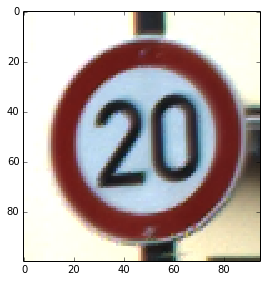

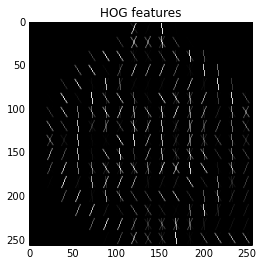

In [17]:
##im1 = zoom(image, 3)
img = io.imread("00147.png")
image = color.rgb2gray(img)

cell_size = (16, 16)
cells_per_block=(8, 8)
n_bins = 9
hog_hist = calc_HOG(image, cell_size=(16, 16), simple_kernel = False, cells_per_block=cells_per_block, n_bins = n_bins)
hog_image = draw_hist(hog_hist, cell_size = cell_size)

plt.show()
io.imshow(img)
io.show()
plt.figure()
plt.title('HOG features')
plt.imshow(hog_image, cmap=plt.cm.Greys_r)


# SVM классификация.

Когда мы научились извлекать признаки, и у нас есть обучающая и тестовые выборки, можно воспользоваться машинным обучением.

Сохранила параметры для оптимального классификатора, найденного GridSearch.

In [32]:
svm = SVC(C=1000.0, cache_size=200, coef0=0.0, degree=3,
  gamma=0.001, max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
svm.fit(X_train_pca, y_train)

SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

calc_hog_features открывает все изображения в директории и извлекает из них hog фичи.

In [31]:
def calc_hog_features(read_dir, filenames, way = False):
    print "Feature calc bigin. \n"
    os.chdir(read_dir)
    X = []
    train_num = len(filenames)

    for i in range(train_num):
        if i % 2000 == 0:
            print i, "\n"
        if way:
            f = extract_hog(filenames[i][0], cell_size=(8, 8)).flatten()
        else:
            f = extract_hog(filenames[i], cell_size=(8, 8)).flatten()
        X.append(f)
        X_train = np.array(X)
    return X_train

def write_prediction(y_pred, Filenames_test, write_dir, filename = "ans"):
    os.chdir(write_dir)
    file_ans = open('answers4', 'w')
    file_ans.write("filename,class_id\n")
    for i in range(len(Filenames_test)):
        file_ans.write(Filenames_test[i])
        file_ans.write(",")
        file_ans.write("%s\n" % y_pred[i])

Основная программа. Также имеется возможность загрузить уже построенные диаграммы для тестовой выборки. В файле при этом должны быть записаны как гистограммы, так и разметка признаков.

При SVM классификации я выбираю параметры, подобранные ранее GridSearch. Также я делаю PCA на 150 главных компонент.

In [32]:
def fit_and_classify(load_X = False):
    test_dir = '/home/masha/Desktop/Shad5/Pictures/HW3/test/'
    train_dir = '/home/masha/Desktop/Shad5/Pictures/HW3/train/'
    basic_dir = '/home/masha/Desktop/Shad5/Pictures/HW3/'
    print "Computation begin. \n"
    os.chdir(basic_dir)
    data = pandas.read_csv("gt.csv")
    Filenames, Ids = data.ix[:, :-1].values, data.ix[:, -1].values
    c = zip(Filenames, Ids)
    random.shuffle(c)
    Filenames = [e[0] for e in c]
    Ids = [e[1] for e in c]
    if load_X:
        os.chdir(basic_dir)
        ccc = np.load("X_tr.txt.npy")
        X_train = list(ccc[:, 0])
        X_train = np.array(X_train)
        y_train = ccc[:, 1]
        y_train = np.array(y_train)
    else:
        X_train = calc_hog_features(train_dir, Filenames, way = True)
    print "X_train vectors calculated.\n"
    
    Filenames_test = np.array(sorted(os.listdir(test_dir)))
    X_test = calc_hog_features(test_dir, Filenames_test)
    print "X_test vectors calculated.\n"
    
    print "Computing X train PCA"
    n_components = 150
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))
    t0 = time()
    X_train_pca = pca.transform(X_train)
    print("done in %0.3fs" % (time() - t0))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0)) 
    
    print("Fitting SVM")
    t0 = time()
    svm = SVC(C=1000.0, cache_size=200, coef0=0.0, degree=3,
          gamma=0.001, max_iter=-1, probability=False,
          random_state=None, shrinking=True, tol=0.001, verbose=False)
    svm.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    
    print("Predicting on the test set")
    t0 = time()
    y_pred = svm.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))
    
    write_prediction(y_pred, Filenames_test, basic_dir)
    return y_pred

In [ ]:
fit_and_classify(load_X = True)